# 数据变换

In [1]:
import os
import math
import torch
import random
import numpy as np
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision import models
import tensorwatch as tw

In [2]:
class RandomErasing(object):
    """ 随机选择图像中的矩形区域并擦除其像素。
    参数：
        probability：执行随机擦除操作的概率。
        sl：被擦除区域相对于输入图像的最小比例。
        sh：删除区域相对于输入图像的最大比例。
        r1：被擦除区域的最小纵横比。
        mean：擦除值。 
    """
    
    def __init__(self, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.probability = probability
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.probability:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.size()[2] and h < img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                else:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                return img

        return img

In [3]:
data_dir = "/home/yxy/ReID/data/DukeMTMC-reID/pytorch/"

trainset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                               transforms.Compose([
                                                   #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0),
                                                   transforms.Resize((256,128), interpolation=3),
                                                   transforms.Pad(10),
                                                   transforms.RandomCrop((256,128)),
                                                   transforms.RandomHorizontalFlip(),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                                   RandomErasing(probability = 0, mean=[0.0, 0.0, 0.0])
                                               ]))
trainloaders = torch.utils.data.DataLoader(trainset, batch_size=32,
                                             shuffle=True, num_workers=8, pin_memory=True) 


testset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                            transforms.Compose([
                                                transforms.Resize(size=(256,128),interpolation=3), #Image.BICUBIC
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                            ]))
testloaders = torch.utils.data.DataLoader(testset, batch_size=32,
                                             shuffle=True, num_workers=8, pin_memory=True)


## 展示一张图片

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


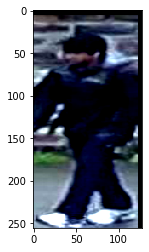

In [4]:
def imshow(img):
    img = img / 2 + 0.5   #-1,1 to 0,1
    npimg = img.numpy()   #转为numpy数组
    plt.imshow(np.transpose(npimg,(1,2,0)))  #3*32*32转为32*32*3
    plt.show()

#show images
imshow(trainset[0][0])

# 搭建模型

In [5]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in') # For old pytorch, you may use kaiming_normal.
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
        init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm1d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.normal_(m.weight.data, std=0.001)
        init.constant_(m.bias.data, 0.0)

In [6]:
class ClassBlock(nn.Module):
    def __init__(self, input_dim, class_num, droprate, relu=False, bnorm=True, num_bottleneck=512, linear=True, return_f = False):
        super(ClassBlock, self).__init__()
        self.return_f = return_f
        add_block = []
        if linear:
            add_block += [nn.Linear(input_dim, num_bottleneck)]
        else:
            num_bottleneck = input_dim
        if bnorm:
            add_block += [nn.BatchNorm1d(num_bottleneck)]
        if relu:
            add_block += [nn.LeakyReLU(0.1)]
        if droprate>0:
            add_block += [nn.Dropout(p=droprate)]
        add_block = nn.Sequential(*add_block)
        add_block.apply(weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(num_bottleneck, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(weights_init_classifier)

        self.add_block = add_block
        self.classifier = classifier
    def forward(self, x):
        x = self.add_block(x)
        if self.return_f:
            f = x
            x = self.classifier(x)
            return x,f
        else:
            x = self.classifier(x)
            return x

In [7]:
class ft_net(nn.Module):

    def __init__(self, class_num, droprate=0.5, stride=2):
        super(ft_net, self).__init__()
        model_ft = models.resnet50(pretrained=True)
        if stride == 1:
            model_ft.layer4[0].downsample[0].stride = (1,1)
            model_ft.layer4[0].conv2.stride = (1,1)
        model_ft.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.model = model_ft
        self.classifier = ClassBlock(2048, class_num, droprate)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.classifier(x)
        return x

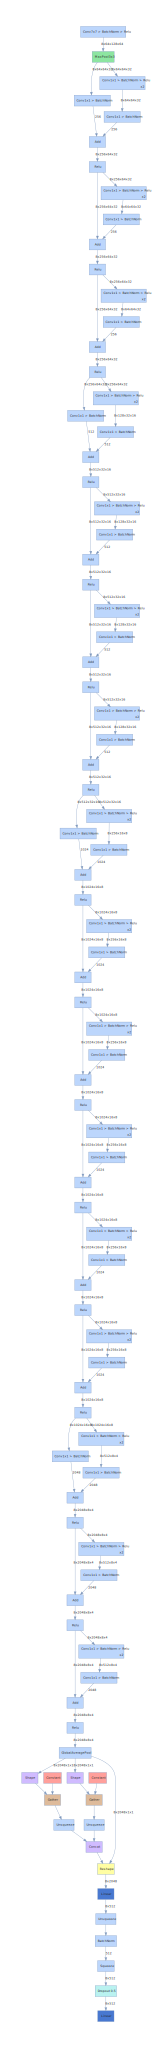

In [8]:
net = ft_net(702,stride=2)
tw.draw_model(net,[8, 3, 256, 128])

# 网络测试

tensor([[ 0.0635,  0.0418, -0.0045,  ..., -0.0419,  0.0150,  0.0149],
        [ 0.0266,  0.0226, -0.0195,  ...,  0.0551, -0.0244,  0.0322],
        [ 0.0125,  0.0224, -0.0123,  ..., -0.0198,  0.0336, -0.0243],
        ...,
        [-0.0412,  0.0452, -0.0119,  ..., -0.0340, -0.0720,  0.0262],
        [ 0.0367,  0.0254,  0.0007,  ...,  0.0232, -0.0300, -0.0262],
        [ 0.0093,  0.0067,  0.0333,  ..., -0.0053,  0.0068,  0.0071]],
       grad_fn=<AddmmBackward>)


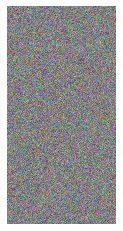

In [9]:
x = torch.randn((10,3,256,128))
x = x / torch.max(x)
im = (x[0]-torch.min(x[0]))/(torch.max(x[0])-torch.min(x[0]))
plt.imshow(np.transpose(im,(1,2,0)))
plt.axis('off')
print(net(x))

# 开始训练

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device) 

ft_net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(6

In [11]:
criterion = nn.CrossEntropyLoss() #交叉熵损失函数

In [12]:
#权重和偏置设置不同的学习率
ignored_params = list(map(id,net.classifier.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params, net.parameters())
optimizer = optim.SGD([
             {'params': base_params, 'lr': 0.1*0.05},
             {'params': net.classifier.parameters(), 'lr': 0.05}
         ], weight_decay=5e-4, momentum=0.9, nesterov=True)

In [13]:
# save model
def save_network(network, epoch_label):
    save_filename = 'net_%s.pth'% epoch_label
    save_path = os.path.join('./model/',save_filename)
    torch.save(network.state_dict(),save_path)

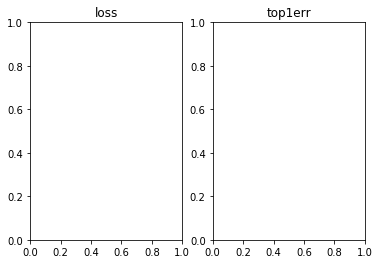

In [14]:
# Draw Curve
x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="top1err")
def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss, 'bo-', label='train')
    ax0.plot(x_epoch, y_loss1, 'ro-', label='val')
    ax1.plot(x_epoch, y_err, 'bo-', label='train')
    ax1.plot(x_epoch, y_err1, 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    save_jpg = 'train_%s.jpg' % current_epoch
    fig.savefig( os.path.join('./curve/',save_jpg))

In [ ]:
#warm_up = 0.1
#warm_iteration = round(dataset_sizes['train']/32) * 5
y_loss = []
y_loss1 = []
y_err= []
y_err1 = []
num_epochs = 61

for epoch in range(num_epochs):
    print('Epoch{}/{}'.format(epoch,num_epochs - 1))
    print('-' * 20)
    
    running_loss = 0.0 
    running_corrects = 0.0
    running_loss1 = 0.0 
    running_corrects1 = 0.0
    
    for i,data in enumerate(trainloaders):
        inputs,labels = data
        now_batch_size, c, h, w = inputs.shape
        if now_batch_size < 32: # 跳出最后一次batch
            continue
        inputs,labels = Variable(inputs.to(device)), Variable(labels.to(device))
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        _,preds = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()* now_batch_size
        running_corrects += float(torch.sum(preds == labels.data))
        
    for i,data in enumerate(testloaders):
        inputs,labels = data
        now_batch_size, c, h, w = inputs.shape
        if now_batch_size < 32: # 跳出最后一次batch
            continue
        inputs,labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        with torch.no_grad():
            outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        
        running_loss1 += loss.item()* now_batch_size
        running_corrects1 += float(torch.sum(preds == labels.data))
        
        
    epoch_loss = running_loss / len(trainset)
    epoch_acc = running_corrects / len(trainset)
    
    epoch_loss1 = running_loss1 / len(testset)
    epoch_acc1 = running_corrects1 / len(testset)
    
    y_loss.append(epoch_loss)
    y_loss1.append(epoch_loss1)    
    y_err.append(1.0 - epoch_acc)
    y_err1.append(1.0- epoch_acc1)
    
    if epoch % 10 == 9:
        save_network(net, epoch)
    draw_curve(epoch)
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss1, epoch_acc1))
    
print('train finished')

Epoch0/60
--------------------
train Loss: 3.5003 Acc: 0.3464
test Loss: 1.5879 Acc: 0.5684
Epoch1/60
--------------------
train Loss: 1.0636 Acc: 0.7370
test Loss: 0.8824 Acc: 0.7393
Epoch2/60
--------------------
train Loss: 0.5957 Acc: 0.8480
test Loss: 0.7954 Acc: 0.7479
Epoch3/60
--------------------
train Loss: 0.3773 Acc: 0.9028
test Loss: 0.5837 Acc: 0.8077
Epoch4/60
--------------------
train Loss: 0.2711 Acc: 0.9332
test Loss: 0.4760 Acc: 0.8462
Epoch5/60
--------------------
train Loss: 0.1885 Acc: 0.9534
test Loss: 0.4309 Acc: 0.8632
Epoch6/60
--------------------
train Loss: 0.1517 Acc: 0.9659
test Loss: 0.3883 Acc: 0.8761
Epoch7/60
--------------------


In [ ]:
torch.save(net.state_dict(), './model/resnet_croess.pth')